In [1]:
import xarray as xr
import climetlab as cml
import numpy as np
from src.utils import *
import pandas as pd

/home/ubuntu/miniconda3/envs/weather/lib/python3.8/site-packages/ecmwflibs/__init__.py:83: UserWarning: /lib/x86_64-linux-gnu/libgobject-2.0.so.0: undefined symbol: ffi_type_uint32, version LIBFFI_BASE_7.0
  warnings.warn(str(e))
/home/ubuntu/miniconda3/envs/weather/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


# Ensemble Learning

## Stacked Generalization

[good resource](https://machinelearningmastery.com/implementing-stacking-scratch-python/)

We use the results of our previous models as a feature set, and train a Linear or Logistic Regression model on it. 

Models used as features:
- Climatology
- Persistence
- Convolutional Neural Network
- Artificial Neural Network
- Residual Neural Network

In [2]:
temperature = pd.read_csv("../forecasts/temperature_forecasts.csv")
temperature

,time,lat,lon,cnn,persistence,ann,resnet,climatology,linreg,true
0,2018-12-02 00:00:00,19.6875,-129.375,23.539154,22.628998,23.539154,22.525696,20.562073,22.635956,22.199127
1,2018-12-02 00:00:00,19.6875,-123.750,23.362488,22.402191,23.362488,21.948486,20.387848,22.236237,21.710602
2,2018-12-02 00:00:00,19.6875,-118.125,23.290802,22.865631,23.290802,22.185303,20.970978,22.797913,21.457000
3,2018-12-02 00:00:00,19.6875,-112.500,24.537994,25.372528,24.537994,23.614227,23.275848,25.416962,22.807190
4,2018-12-02 00:00:00,19.6875,-106.875,27.547943,28.456604,27.547943,25.080658,26.250030,28.418701,25.449890
...,...,...,...,...,...,...,...,...,...,...
65515,2018-12-31 23:00:00,53.4375,-84.375,-13.972565,-13.058136,-13.972565,-17.864258,-9.779297,-7.108337,-31.794373
65516,2018-12-31 23:00:00,53.4375,-78.750,-13.108978,-12.339111,-13.108978,-15.618896,-9.195404,-6.959992,-29.186462
65517,2018-12-31 23:00:00,53.4375,-73.125,-14.566071,-17.471283,-14.566071,-16.486969,-12.881866,-11.153992,-21.048325
65518,2018-12-31 23:00:00,53.4375,-67.500,-15.086334,-21.812088,-15.086334,-16.945892,-20.047516,-16.290161,-25.490463


In [3]:
times = []
for t in temperature.time:
    if t[-8:] not in times:
        times.append(t[-8:])
times

['00:00:00',
 '01:00:00',
 '02:00:00',
 '03:00:00',
 '04:00:00',
 '05:00:00',
 '06:00:00',
 '07:00:00',
 '08:00:00',
 '09:00:00',
 '10:00:00',
 '11:00:00',
 '12:00:00',
 '13:00:00',
 '14:00:00',
 '15:00:00',
 '16:00:00',
 '17:00:00',
 '18:00:00',
 '19:00:00',
 '20:00:00',
 '21:00:00',
 '22:00:00',
 '23:00:00']

In [4]:
def find_k(k):
    train_times = times[::2]
    test_times = list(set(times) - set(train_times))
    weights = []
    for i, t in enumerate(train_times):
        valid_times = np.array([np.array([i for i in range(91)])+(k*24+i)*91 for k in range(5)]).flatten()
        working_data = temperature.iloc[valid_times][['lat', 'lon', 'cnn', 'ann', 'resnet', 'climatology']]
        y = temperature.iloc[valid_times][['true']]
        A = np.array(working_data)
        w = np.linalg.inv(A.T@A + k*np.identity(6))@A.T@y
        weights.append(np.array(w))
    preds = []
    losses = []
    for i, t in enumerate(test_times):
        valid_times = np.array([np.array([i for i in range(91)])+(k*24+i)*91 for k in range(5)]).flatten()
        working_data = temperature.iloc[valid_times][['lat', 'lon', 'cnn', 'ann', 'resnet', 'climatology']]
        y = temperature.iloc[valid_times][['true']]
        A = np.array(working_data)
        preds.append(A@weights[i])
        l = A@weights[i] - np.array(y)
        losses.append(l.T@l.flatten())
    return preds, np.sum(np.array(losses).flatten())

0.0002909090909090909

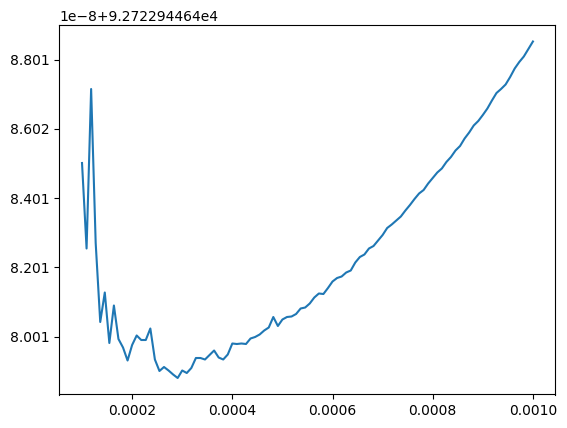

In [5]:
import matplotlib.pyplot as plt
k = np.linspace(0.0001, 0.001, 100)
x = [find_k(i)[1] for i in k]
plt.plot(k, x)
k[np.argmin(x)]

In [6]:
best = np.array(find_k(k[np.argmin(x)])[0]).squeeze()

In [7]:
best

array([[ 21.44004693,  20.84911484,  21.44504921, ..., -14.19787437,
        -17.01183626, -12.43651296],
       [ 20.58541948,  20.06187208,  20.78976815, ..., -14.61540429,
        -17.45103271, -12.71230918],
       [ 19.59574576,  19.23540864,  20.11897575, ..., -15.21953182,
        -17.93715819, -13.36586869],
       ...,
       [ 18.0281587 ,  17.91397618,  18.94057431, ..., -15.55086981,
        -19.06389866, -16.66943439],
       [ 18.2409428 ,  18.2892809 ,  19.36732699, ..., -16.23741235,
        -19.39237575, -17.31198714],
       [ 18.375906  ,  18.38560189,  19.40652211, ..., -16.11712526,
        -19.21817548, -17.07589191]])

In [8]:
temperature = pd.read_csv("../forecasts/precipitation_forecasts.csv")
times = []
for t in temperature.time:
    if t[-8:] not in times:
        times.append(t[-8:])
def find_k(k):
    train_times = times[::2]
    test_times = list(set(times) - set(train_times))
    weights = []
    for i, t in enumerate(train_times):
        valid_times = np.array([np.array([i for i in range(91)])+(k*24+i)*91 for k in range(5)]).flatten()
        working_data = temperature.iloc[valid_times][['lat', 'lon', 'cnn', 'ann', 'resnet', 'climatology']]
        y = temperature.iloc[valid_times][['true']]
        A = np.array(working_data)
        w = np.linalg.inv(A.T@A + k*np.identity(6))@A.T@y
        weights.append(np.array(w))
    preds = []
    losses = []
    for i, t in enumerate(test_times):
        valid_times = np.array([np.array([i for i in range(91)])+(k*24+i)*91 for k in range(5)]).flatten()
        working_data = temperature.iloc[valid_times][['lat', 'lon', 'cnn', 'ann', 'resnet', 'climatology']]
        y = temperature.iloc[valid_times][['true']]
        A = np.array(working_data)
        preds.append(A@weights[i])
        l = A@weights[i] - np.array(y)
        losses.append(l.T@l.flatten())
    return preds, np.sum(np.array(losses).flatten())

2.0408163363265304e-09

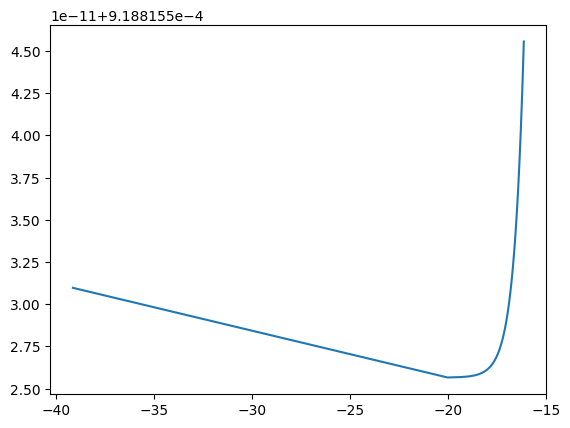

In [9]:
import matplotlib.pyplot as plt
k = np.linspace(10**-17, 10**-7, 50)
x = [find_k(i)[1] for i in k]
plt.plot(np.log(k), x)
k[np.argmin(x)]

In [10]:
best = np.array(find_k(k[np.argmin(x)])[0]).squeeze()